# Baseline implementation of relevant error rate-based change-detection algorithms

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from dash import Dash, html, dcc, callback, Output, Input

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Data Loading

Loading the needed datasets. 

In [7]:
# Load data
test1 = pd.read_csv("/Users/emmatosato/Documents/UNI_Locale/Erasmus/OST/ost-sm-change-detection/static_work/data_analysis/merged_data/test_pd1.csv")
test2= pd.read_csv("/Users/emmatosato/Documents/UNI_Locale/Erasmus/OST/ost-sm-change-detection/static_work/data_analysis/merged_data/test_pd2.csv")

In [8]:
# Load data
test1_scaled = pd.read_csv("/Users/emmatosato/Documents/UNI_Locale/Erasmus/OST/ost-sm-change-detection/static_work/data_analysis/preprocessed_data/scaled_test1.csv")
test2_scaled = pd.read_csv("/Users/emmatosato/Documents/UNI_Locale/Erasmus/OST/ost-sm-change-detection/static_work/data_analysis/preprocessed_data/scaled_test2.csv")

## Functions

### Evaluation

These functions assess the performance of change detection algorithms:
- calculate_delay_of_detection: Computes the average delay between true and detected change points.

- calculate_false_detection_rate: Calculates the rate of false detections relative to the total number of true change points.

- calculate_miss_detection_rate: Determines the rate of missed detections by comparing detected points with true change points.

- calculate_rate_of_drift: Measures the rate of detected changes over the total observation time.

In [9]:
# Definitions of functions
def calculate_delay_of_detection(true_change_indexes, detected_indexes):
    delays = [index - detected_index for detected_index, index in zip(detected_indexes, true_change_indexes)]

    if len(delays) > 0:
        average_delay = sum(delays) / len(delays)
        return average_delay
    else:
        return 0  

def calculate_false_detection_rate(true_change_indexes, detected_indexes):
    total_drifts = len(true_change_indexes)
    total_detected = len(detected_indexes)
    false_detections = total_detected - total_drifts
    fdr = false_detections / total_drifts
    return fdr

def calculate_miss_detection_rate(true_change_indexes, detected_indexes):
    total_drifts = len(true_change_indexes)
    total_detected = len(detected_indexes)
    mdr = (total_drifts - total_detected) / total_drifts
    return mdr

def calculate_rate_of_drift(detected_indexes, total_time):
    total_detected = len(detected_indexes)
    rod = total_detected / total_time
    return rod

## Classification model

Code for using a Random Forest classifier on a dataset.

Data Preprocessing:
- Extracts features (X) and labels (y) from the dataset.
- Splits the data into training and test sets.
- Scales the feature data (X) for a separate model using test1_scaled.

In [10]:
X = test1.iloc[:,1:].drop(['label'], axis=1)
X_scaled = test1_scaled.iloc[:,1:].drop(['label'], axis=1)
y = test1['label']

Model Training and Prediction:
- Trains a Random Forest model on the original and scaled datasets.
- Makes predictions on the test sets.

In [11]:
# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(X, y.ravel(), test_size=0.2, random_state=42)

# Rename
train_labels = pd.DataFrame({'label': train_labels})
test_labels = pd.DataFrame({'label': test_labels})

stream_size = test_data.shape[0]
true_attack_indexes = test_labels[test_labels['label'] == 1].index.values

# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=42)
rf_model.fit(train_data, train_labels)

# Make predictions on the test set
rf_predictions = rf_model.predict(test_data)

/var/folders/07/b_mqfzkn0fzbvjz9y6nbfyf40000gn/T/ipykernel_41350/3876213612.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(train_data, train_labels)


In [12]:
# Split the data into training and test sets
train_scaled, test_scaled, train_labels_scaled, test_labels_scaled = train_test_split(X_scaled, y.ravel(), test_size=0.2, random_state=42)

# Rename
train_labels_scaled = pd.DataFrame({'label': train_labels_scaled})
test_labels_scaled = pd.DataFrame({'label': test_labels_scaled})

true_attack_indexes_sc = test_labels_scaled[test_labels_scaled['label'] == 1].index.values

# Train a Random Forest model
rf_model_scaled = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_scaled.fit(train_scaled, train_labels_scaled)

# Make predictions on the test set
rf_predictions_scaled = rf_model_scaled.predict(test_scaled)

/var/folders/07/b_mqfzkn0fzbvjz9y6nbfyf40000gn/T/ipykernel_41350/625309656.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_scaled.fit(train_scaled, train_labels_scaled)


Accuracy Calculation and confusion matrices calculations: the code computes the accuracy scores for both the original and scaled models.

In [13]:
# Accuracies
acc = accuracy_score(test_labels, rf_predictions)
print(acc)

acc_scaled = accuracy_score(test_labels_scaled, rf_predictions_scaled)
print(acc_scaled)

# Calculate confusion matrix for scaled model
conf_matrix_scaled = confusion_matrix(test_labels, rf_predictions_scaled)
conf_matrix_non_scaled = confusion_matrix(test_labels_scaled, rf_predictions_scaled)

0.9996296296296296
0.9996296296296296


Visualization.

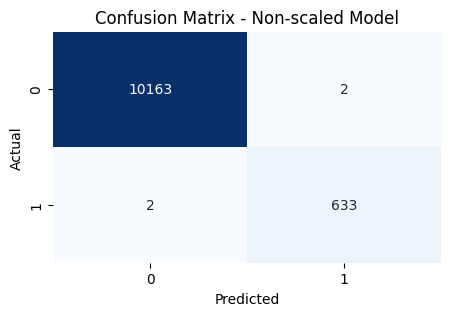

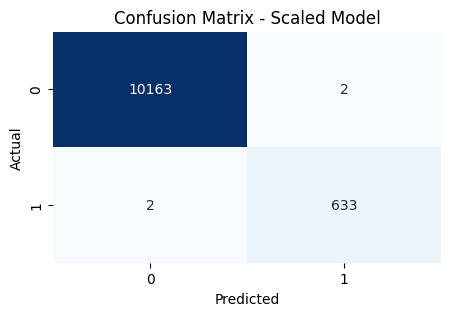

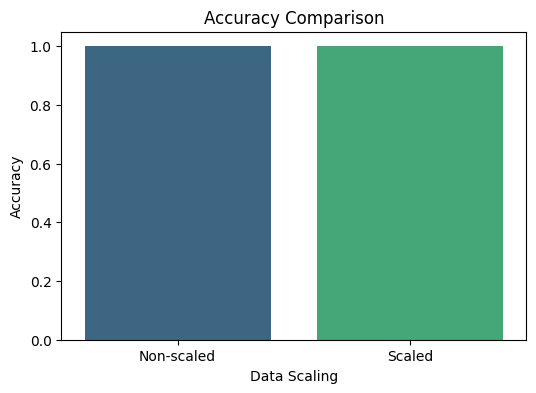

In [14]:
# Confusion Matrix Heatmap - Non-scaled
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_non_scaled, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Non-scaled Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Confusion Matrix Heatmap - Scaled
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix_scaled, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Scaled Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy Comparison Bar Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=["Non-scaled", "Scaled"], y=[acc, acc_scaled], palette="viridis")
plt.title("Accuracy Comparison")
plt.xlabel("Data Scaling")
plt.ylabel("Accuracy")
plt.show()

## CUMSUM Algorithm

The cumulative sum (CUSUM) test is designed to give an alarm when the mean of the input data significantly deviates from its previous value.

*References :*
- Machine Learning for Data Streams book
- Thomas, Flynn, and Yoo Shinjae. Change Detection with the Kernel Cumulative Sum Algorithm. ArXiv E-prints, 2017, https://doi.org/10.48550/arXiv.1903.01661.

In [27]:
class CUSUM:
    def __init__(self, k=0.5, h=5):
        self.k = k
        self.h = h
        self.g = 0

    def add_element(self, error):
        zt = error
        self.g = max(0, self.g + zt - self.k)

    def check_drift(self):
        return self.g > self.h


In [80]:
# Create an instance of the CUSUM class
cusum_detector = CUSUM(k=0.1, h=2)  

# List to store detected change points using CUSUM
detected_indexes_cusum = []

# Iterate through the DataFrame and apply CUSUM
for i in range(stream_size):
    prediction = rf_predictions[i]
    label = test_labels['label'].iloc[i]

    # Update CUSUM with the label (1 for anomaly, 0 for normal)
    cusum_detector.add_element(label)

    # Check for drift detection after processing each element
    if cusum_detector.check_drift():
        detected_indexes_cusum.append(i)

# Print or use the detected change points
print("Detected Change Points (CUSUM):", detected_indexes_cusum)

Detected Change Points (CUSUM): [157, 158, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1154, 1155, 1156, 1157, 1158, 1248, 1249, 1250, 1260, 1267, 1268, 1269, 1270, 1482, 1483, 1484, 1485, 1486, 1487, 1798, 1799, 1804, 1805, 1806, 1807, 1808, 1809, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1893, 1894, 1895, 1999, 2000, 2001, 2002, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2019, 2020, 2021, 2022, 2431, 2432, 2462, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2481, 2482, 2502, 3559, 3560, 3561, 3562, 3563, 3564, 3565, 3566, 3567, 3568, 3569, 3570, 3578, 3579, 3580, 3608, 3609, 3610, 3638, 3639, 3640, 3725, 3726, 3727, 3728, 3729, 3730, 3731, 3732, 3733, 3734, 3735, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752,

In [81]:
# Evaluate change detection performance using CUSUM
average_delay_cusum = calculate_delay_of_detection(true_attack_indexes, detected_indexes_cusum)
fdr_cusum = calculate_false_detection_rate(true_attack_indexes, detected_indexes_cusum)
mdr_cusum = calculate_miss_detection_rate(true_attack_indexes, detected_indexes_cusum)
rod_cusum = calculate_rate_of_drift(detected_indexes_cusum, total_time=stream_size - 500)

In [82]:
# Print evaluation metrics for EDDM
print("EDDM Metrics:")
print("Average Delay:", average_delay_cusum)
print("False Detection Rate (FDR):", fdr_cusum)
print("Miss Detection Rate (MDR):", mdr_cusum)
print("Rate of Drift (ROD):", rod_cusum)

EDDM Metrics:
Average Delay: 21011.28503937008
False Detection Rate (FDR): 0.42362204724409447
Miss Detection Rate (MDR): -0.42362204724409447
Rate of Drift (ROD): 0.08776699029126214


## Early Drift Detection Method (EDDM)

This method works by keeping track of the average distance between two errors instead of only the error rate. For this, it is necessary to keep track of the running average distance and the running standard deviation, as well as the maximum distance and the maximum standard deviation.

The algorithm works similarly to the DDM algorithm. Like DDM, there are two threshold values that define the borderline between no change, warning zone, and drift detected.
These are as follows:

**Warning zone**
$$ \frac{(p_i + 2 * s_i)}{(p_{max} + 2 * s_{max})} < \alpha $$ 

**Change detected**

$$\frac{(p_i + 2 * s_i)}{(p_{max} + 2 * s_{max})} < \beta $$ 




$\alpha$ and  $\beta$ are set to 0.95 and 0.9, respectively.


<br><br>

*References:*
Early Drift Detection Method. Manuel Baena-Garcia, Jose Del Campo-Avila, Raúl Fidalgo, Albert Bifet, Ricard Gavalda, Rafael Morales-Bueno. In Fourth International Workshop on Knowledge Discovery from Data Streams, 2006.

In [62]:
import numpy as np

class EDDM:
    def __init__(self, alpha=0.95, beta=0.9, min_num_instances=30):
        self.alpha = alpha
        self.beta = beta
        self.min_num_instances = min_num_instances

        # Initialize attributes
        self.n = 0
        self.in_concept_change = 0
        self.in_warning_zone = 0
        self.delay = 0
        self.num_errors = 0
        self.last_d = 0
        self.d = 0
        self.mean = 0
        self.std_temp = 0
        self.estimation = 0
        self.m2s_max = 0

    def add_element(self, prediction):
        self.in_concept_change = 0
        self.n += 1

        if prediction == 1.0:
            self.in_warning_zone = 0
            self.delay = 0
            self.num_errors += 1
            self.last_d = self.d
            self.d = self.n - 1
            distance = self.d - self.last_d
            old_mean = self.mean
            self.mean = self.mean + (float(distance) - self.mean) / self.num_errors
            self.estimation = self.mean
            self.std_temp = self.std_temp + (distance - self.mean) * (distance - old_mean)
            std = np.sqrt(self.std_temp / self.num_errors)
            m2s = self.mean + 2 * std

            if self.n < self.min_num_instances:
                return

            if m2s > self.m2s_max:
                self.m2s_max = m2s
            else:
                p = m2s / self.m2s_max
                threshold_warning = (self.mean + 2 * std) / (self.m2s_max + 2 * np.sqrt(self.std_temp))
                threshold_drift = threshold_warning * self.beta

                if (self.num_errors > self.min_num_instances) and (p < self.alpha):
                    self.in_concept_change = 1
                elif (self.num_errors > self.min_num_instances) and (p < self.beta):
                    self.in_warning_zone = 1

                else:
                    self.in_warning_zone = 0

    def detected_warning_zone(self):
        return self.in_warning_zone

    def detected_change(self):
        return self.in_concept_change

In [76]:
# Create an instance of the EDDM class
eddm_detector = EDDM()

# List to store detected change points using EDDM
detected_indexes_eddm = []

# Iterate through the DataFrame and apply EDDM
for i in range(stream_size):
    prediction = rf_predictions[i]
    label = test_labels['label'].iloc[i]

    # Update EDDM with the label (1 for anomaly, 0 for normal)
    eddm_detector.add_element(label)

    # Check for change detection after processing each element
    if eddm_detector.detected_change():
        detected_indexes_eddm.append(i)

# Print or use the detected change points
print("Detected Change Points (EDDM):", detected_indexes_eddm)

Detected Change Points (EDDM): [555, 574, 640, 648, 661, 664, 683, 689, 693, 712, 730, 771, 779, 833, 846, 1104, 1108, 1128, 1150, 1151, 1154, 1179, 1192, 1222, 1227, 1238, 1242, 1248, 1260, 1267, 1318, 1375, 1481, 1482, 1815, 1818, 1826, 1889, 1893, 1909, 1925, 1928, 1966, 1968, 1994, 1997, 1999, 2005, 2019, 2045, 2055, 2056, 2077, 2094, 2108, 2129, 2131, 2152, 2164, 2177, 2194, 2217, 2227, 2245, 2279, 2291, 2299, 2316, 2344, 2359, 2383, 2386, 2405, 2424, 2426, 2431, 2451, 2453, 2462, 2471, 2473, 2497, 2502, 2526, 2543, 2584, 2593, 2596, 2604, 2615, 2627, 2634, 2673, 2696, 2720, 2726, 2742, 2756, 2758, 2773, 2800, 2818, 2825, 2866, 2877, 2881, 2899, 2914, 2918, 2931, 2936, 2973, 3013, 3018, 3024, 3114, 3125, 3154, 3162, 3206, 3225, 3235, 3236, 3249, 3285, 3309, 3323, 3325, 3339, 3352, 3354, 3382, 3395, 3410, 3416, 3485, 3511, 3518, 3526, 3542, 3543, 3553, 3559, 3561, 3578, 3591, 3602, 3608, 3630, 3633, 3638, 3656, 3685, 3688, 3717, 3724, 3725, 3726, 3738, 3739, 3740, 3741, 3745, 3746,

In [77]:
# Evaluate change detection performance using EDDM
average_delay_eddm = calculate_delay_of_detection(true_attack_indexes, detected_indexes_eddm)
fdr_eddm = calculate_false_detection_rate(true_attack_indexes, detected_indexes_eddm)
mdr_eddm = calculate_miss_detection_rate(true_attack_indexes, detected_indexes_eddm)
rod_eddm = calculate_rate_of_drift(detected_indexes_eddm, total_time=stream_size - 500)

In [78]:
# Print evaluation metrics for EDDM
print("EDDM Metrics:")
print("Average Delay:", average_delay_eddm)
print("False Detection Rate (FDR):", fdr_eddm)
print("Miss Detection Rate (MDR):", mdr_eddm)
print("Rate of Drift (ROD):", rod_eddm)

EDDM Metrics:
Average Delay: 20736.112704918032
False Detection Rate (FDR): -0.231496062992126
Miss Detection Rate (MDR): 0.231496062992126
Rate of Drift (ROD): 0.04737864077669903


## ADaptive WINdowing (ADWIN)

**ADWIN (ADaptive WINdowing)** is an adaptive sliding window algorithm for detecting change, and keeping updated statistics about a data stream.
ADWIN allows algorithms not adapted for drifting data, to be resistant to this phenomenon.

The general idea is to keep statistics from a window of variable size while detecting concept drift.

The algorithm will decide the size of the window by cutting the statistics' window at different points and analysing the average of some statistic over these two windows. If the absolute value of the difference between the two averages surpasses a pre-defined threshold, change is detected at that point and all data before that time is discarded.


In [ ]:
class ADWIN:
    def __init__(self, delta=0.002):
        self.delta = delta
        self.window = []
        self.total_count = 0

    def add_element(self, error):
        self.window.append(error)
        self.total_count += 1

        if len(self.window) > 1:
            self.check_drift()

    def check_drift(self):
        num_buckets = len(self.window)

        for i in range(1, num_buckets):
            w0 = self.window[:i]
            w1 = self.window[i:]

            if self.test(w0, w1):
                self.window.pop(0)
                break

    def test(self, w0, w1):
        mean_w0 = sum(w0) / len(w0) if len(w0) > 0 else 0
        mean_w1 = sum(w1) / len(w1) if len(w1) > 0 else 0

        var_w0 = sum((x - mean_w0) ** 2 for x in w0) / len(w0) if len(w0) > 1 else 0
        var_w1 = sum((x - mean_w1) ** 2 for x in w1) / len(w1) if len(w1) > 1 else 0

        if mean_w1 == 0:
            return False

        p_value = (mean_w0 + 2 * (var_w0 ** 0.5)) / (mean_w1 + 2 * (var_w1 ** 0.5))
        
        return p_value < self.delta



In [ ]:
# Initialize ADWIN for change detection
adwin = ADWIN(delta=0.002)

# List detected change points
detected_indexes_adwin = []

for i in range(stream_size):
    error = int(rf_model_predictions[i] != test_labels.iloc[i])

    # Update ADWIN with the error signal
    adwin.add_element(error)

    # Check for change detection
    if adwin.check_drift():
        detected_indexes_adwin.append(i)

In [ ]:
# Evaluate change detection performance using ADWIN
average_delay_adwin = calculate_delay_of_detection(true_attack_indexes, detected_indexes_adwin)
fdr_adwin = calculate_false_detection_rate(true_attack_indexes, detected_indexes_adwin)
mdr_adwin = calculate_miss_detection_rate(true_attack_indexes, detected_indexes_adwin)
rod_adwin = calculate_rate_of_drift(detected_indexes_adwin, total_time=stream_size - 500)